### Imports 

In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

#### Mount your google drive so you can save model checkpoints, and report your test results on the final best model after hyperparameter tuning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [3]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [5]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).


    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [6]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [7]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [8]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

In [9]:
for i, _ in train_loader:
  print(i.shape)
  break

torch.Size([128, 3, 32, 32])


### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [23]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader, model_name, log_print = True, max_patience = 5, max_iter=50, check_capacity = False):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = max_patience
    patience_counter = 0

    # Training
    for t in tqdm(range(max_iter)):

        # TODO : Set the model to train mode
        model.train()   

        # TODO: Loop over the training set 
        correct, total, train_loss = 0, 0, 0
        for inputs, targets in train_loader:

            # TODO: Put the inputs and targets on the write device
            inputs, targets = inputs.to(device), targets.to(device)

            # TODO: Feed forward to get the logits
            logits = model(inputs)

            # TODO: Compute the loss and accuracy
            batch_accs = [0]
            loss = criterion(logits, targets)
            train_loss += targets.size(0) * loss.item()
            _, predicted = torch.max(logits, 1)
            correct += predicted.eq(targets).cpu().sum().item()
            total += targets.size(0)
            if check_capacity:
              batch_accs.append(predicted.eq(targets).cpu().sum().item()/targets.size(0))

            # TODO: zero the gradients before running
            # the backward pass.
            model.zero_grad()

            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()

            # TODO: Update params
            optimizer.step()

            # TODO: Keep track of accuracy and loss
        train_losses.append(train_loss/total)
        train_accuracies.append(correct/total)

        if max(batch_accs) == 1:
          print('There is one batch achieving 100% accuracy')
          break
        
        # TODO: Switch the model to eval mode
        model.eval()
        with torch.no_grad():
            # TODO: Loop over the validation set
            val_correct, val_total, val_loss = 0, 0, 0
            for inputs, targets in val_loader:
            
                # TODO: Put the inputs and targets on the write device
                inputs, targets = inputs.to(device), targets.to(device)
            
                # TODO: Feed forward to get the logits
                logits = model(inputs)

                # TODO: Compute the loss and accuracy
                loss = criterion(logits, targets)
                val_loss += targets.size(0) * loss.item()
                _, predicted = torch.max(logits, 1)
                val_correct += predicted.eq(targets).cpu().sum().item()
                val_total += targets.size(0)

                # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss/val_total)
            val_accuracies.append(val_correct/val_total)

        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          torch.save({
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': t,
              }, '/content/drive/My Drive/1008_DL_Homework2/model_checkpoints/{}_checkpoint.pth'.format(model_name))

          
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break
        
        if log_print == True:
          print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
          print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

### Q 2.2 Shallow convolutional network. 

In [15]:
class View(nn.Module):
    def __init__(self, shape):
      super().__init__()
      self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [11]:
ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [13]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        """

        Parameters
        ----------
        input_channels : Number of input channels
        num_classes : Number of classes for the final prediction 
        """
        super(ShallowConvnet, self).__init__()
        # TODO
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=8)
        self.view = View((-1,256))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
        """

        Parameters
        ----------
        x

        Returns
        -------
        output : Result after running through the model
        """
        
        # TODO
        out1 = self.conv1(x)
        out2 = self.relu(out1)
        out3 = self.maxpool1(out2)
        out4 = self.conv2(out3)
        out5 = self.relu(out4)
        out6 = self.maxpool2(out5)
        out7 = self.conv3(out6)
        out8 = self.relu(out7)
        out9 = self.maxpool3(out8)
        out10 = self.view(out9)
        output = self.linear(out10)

        return output

        

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [20]:
# TODO : Initialize the model and cast to correct device
model = ShallowConvnet(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model, criterion, optimizer,  train_loader, val_loader, 'ShallowConvnet')

[EPOCH]: 0, [TRAIN LOSS]: 2.284753, [TRAIN ACCURACY]: 0.136
[EPOCH]: 0, [VAL LOSS]: 2.258697, [VAL ACCURACY]: 0.219 

[EPOCH]: 1, [TRAIN LOSS]: 2.232640, [TRAIN ACCURACY]: 0.241
[EPOCH]: 1, [VAL LOSS]: 2.204136, [VAL ACCURACY]: 0.270 

[EPOCH]: 2, [TRAIN LOSS]: 2.170531, [TRAIN ACCURACY]: 0.280
[EPOCH]: 2, [VAL LOSS]: 2.136913, [VAL ACCURACY]: 0.285 

[EPOCH]: 3, [TRAIN LOSS]: 2.101442, [TRAIN ACCURACY]: 0.294
[EPOCH]: 3, [VAL LOSS]: 2.069516, [VAL ACCURACY]: 0.295 

[EPOCH]: 4, [TRAIN LOSS]: 2.039981, [TRAIN ACCURACY]: 0.307
[EPOCH]: 4, [VAL LOSS]: 2.013153, [VAL ACCURACY]: 0.308 

[EPOCH]: 5, [TRAIN LOSS]: 1.989476, [TRAIN ACCURACY]: 0.316
[EPOCH]: 5, [VAL LOSS]: 1.966014, [VAL ACCURACY]: 0.325 

[EPOCH]: 6, [TRAIN LOSS]: 1.946973, [TRAIN ACCURACY]: 0.327
[EPOCH]: 6, [VAL LOSS]: 1.926570, [VAL ACCURACY]: 0.336 

[EPOCH]: 7, [TRAIN LOSS]: 1.908513, [TRAIN ACCURACY]: 0.339
[EPOCH]: 7, [VAL LOSS]: 1.886488, [VAL ACCURACY]: 0.352 

[EPOCH]: 8, [TRAIN LOSS]: 1.871704, [TRAIN ACCURACY]: 0.

### Q2.4 Simple convolution network - 

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. Each convolution layer should be followed by a relu non-linearity. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer that halves the resolution of the image. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [14]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        # TODO
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=8)
        self.view = View((-1,256))
        self.linear = nn.Linear(256, num_classes)

    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        y1 = self.conv1(x)
        y = self.relu(y1)

        # HINT: block of 3 conv 
        l1 = self.conv2(y)
        l2 = self.relu(l1)
        l3 = self.conv3(l2)
        l4 = self.relu(l3)
        l5 = self.conv4(l4)
        l6 = self.relu(l5)
        l = self.maxpool1(l6)

        # HINT : block of 3 conv 
        m1 = self.conv5(l)
        m2 = self.relu(m1)
        m3 = self.conv6(m2)
        m4 = self.relu(m3)
        m5 = self.conv7(m4)
        m6 = self.relu(m5)
        m = self.maxpool2(m6)

        # HINT: block of 3 conv
        n1 = self.conv8(m)
        n2 = self.relu(n1)
        n3 = self.conv9(n2)
        n4 = self.relu(n3)
        n5 = self.conv10(n4)
        n6 = self.relu(n5)
        n = self.maxpool3(n6)

        # HINT: projection
        out = self.view(n)
        output = self.linear(out)
        
        return output
        

In [22]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
SimpleConvnet_train_losses, SimpleConvnet_train_accuracies, SimpleConvnet_val_losses, SimpleConvnet_val_accuracies = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'SimpleConvnet')

[EPOCH]: 0, [TRAIN LOSS]: 2.303101, [TRAIN ACCURACY]: 0.099
[EPOCH]: 0, [VAL LOSS]: 2.303141, [VAL ACCURACY]: 0.103 

[EPOCH]: 1, [TRAIN LOSS]: 2.303059, [TRAIN ACCURACY]: 0.099
[EPOCH]: 1, [VAL LOSS]: 2.303106, [VAL ACCURACY]: 0.103 

[EPOCH]: 2, [TRAIN LOSS]: 2.303020, [TRAIN ACCURACY]: 0.099
[EPOCH]: 2, [VAL LOSS]: 2.303073, [VAL ACCURACY]: 0.103 

[EPOCH]: 3, [TRAIN LOSS]: 2.302984, [TRAIN ACCURACY]: 0.099
[EPOCH]: 3, [VAL LOSS]: 2.303043, [VAL ACCURACY]: 0.103 

[EPOCH]: 4, [TRAIN LOSS]: 2.302951, [TRAIN ACCURACY]: 0.099
[EPOCH]: 4, [VAL LOSS]: 2.303016, [VAL ACCURACY]: 0.103 

[EPOCH]: 5, [TRAIN LOSS]: 2.302921, [TRAIN ACCURACY]: 0.099
[EPOCH]: 5, [VAL LOSS]: 2.302991, [VAL ACCURACY]: 0.103 



### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

Using SGD optimizer, the ShallowNet can achieve a validation accuracy of around 0.55 associated with a training accuracy of around 0.57. But the SimpleConvnet learn little in training process. The training accuracy doesn't change even after 5 epochs.

### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [15]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
        # TODO
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.batchnorm7 = nn.BatchNorm2d(128)
        self.batchnorm8 = nn.BatchNorm2d(256)
        self.batchnorm9 = nn.BatchNorm2d(256)
        self.batchnorm10 = nn.BatchNorm2d(256)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=8)
        self.view = View((-1,256))
        self.linear = nn.Linear(256, num_classes)
    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        y1 = self.conv1(x)
        y2 = self.relu(y1)
        y = self.batchnorm1(y2)

        # HINT: block of 3 conv 
        l1 = self.conv2(y)
        l2 = self.relu(l1)
        b2 = self.batchnorm2(l2)
        l3 = self.conv3(b2)
        l4 = self.relu(l3)
        b3 = self.batchnorm3(l4)
        l5 = self.conv4(b3)
        l6 = self.relu(l5)
        b4 = self.batchnorm4(l6)
        l = self.maxpool1(b4)

        # HINT : block of 3 conv 
        m1 = self.conv5(l)
        m2 = self.relu(m1)
        b5 = self.batchnorm5(m2)
        m3 = self.conv6(b5)
        m4 = self.relu(m3)
        b6 = self.batchnorm6(m4)
        m5 = self.conv7(b6)
        m6 = self.relu(m5)
        b7 = self.batchnorm7(m6)
        m = self.maxpool2(b7)

        # HINT: block of 3 conv
        n1 = self.conv8(m)
        n2 = self.relu(n1)
        b8 = self.batchnorm8(n2)
        n3 = self.conv9(b8)
        n4 = self.relu(n3)
        b9 = self.batchnorm9(n4)
        n5 = self.conv10(b9)
        n6 = self.relu(n5)
        b10 = self.batchnorm10(n6)
        n = self.maxpool3(b10)

        # HINT: projection
        out = self.view(n)
        output = self.linear(out)
        
        return output
        

In [24]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# TODO : Run the training loop using this model
SimpleConvnet2_train_losses, SimpleConvnet2_train_accuracies, SimpleConvnet2_val_losses, SimpleConvnet2_val_accuracies = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'SimpleConvnet2')

[EPOCH]: 0, [TRAIN LOSS]: 1.768807, [TRAIN ACCURACY]: 0.351
[EPOCH]: 0, [VAL LOSS]: 1.529060, [VAL ACCURACY]: 0.445 

[EPOCH]: 1, [TRAIN LOSS]: 1.411814, [TRAIN ACCURACY]: 0.488
[EPOCH]: 1, [VAL LOSS]: 1.370915, [VAL ACCURACY]: 0.501 

[EPOCH]: 2, [TRAIN LOSS]: 1.243256, [TRAIN ACCURACY]: 0.557
[EPOCH]: 2, [VAL LOSS]: 1.273844, [VAL ACCURACY]: 0.552 

[EPOCH]: 3, [TRAIN LOSS]: 1.110357, [TRAIN ACCURACY]: 0.609
[EPOCH]: 3, [VAL LOSS]: 1.212669, [VAL ACCURACY]: 0.566 

[EPOCH]: 4, [TRAIN LOSS]: 0.996494, [TRAIN ACCURACY]: 0.658
[EPOCH]: 4, [VAL LOSS]: 1.155391, [VAL ACCURACY]: 0.588 

[EPOCH]: 5, [TRAIN LOSS]: 0.899496, [TRAIN ACCURACY]: 0.697
[EPOCH]: 5, [VAL LOSS]: 1.118464, [VAL ACCURACY]: 0.602 

[EPOCH]: 6, [TRAIN LOSS]: 0.809831, [TRAIN ACCURACY]: 0.737
[EPOCH]: 6, [VAL LOSS]: 1.105158, [VAL ACCURACY]: 0.605 

[EPOCH]: 7, [TRAIN LOSS]: 0.730583, [TRAIN ACCURACY]: 0.772
[EPOCH]: 7, [VAL LOSS]: 1.075125, [VAL ACCURACY]: 0.618 

[EPOCH]: 8, [TRAIN LOSS]: 0.656242, [TRAIN ACCURACY]: 0.

#### Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 

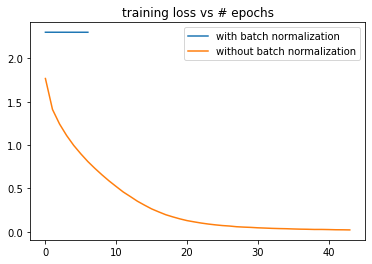

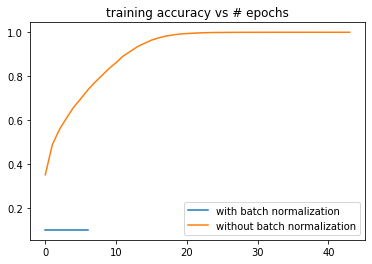

In [25]:
plt.figure()
plt.plot(SimpleConvnet_train_losses, label = 'with batch normalization')
plt.plot(SimpleConvnet2_train_losses, label = 'without batch normalization')
plt.legend()
plt.title('training loss vs # epochs')
plt.show()

plt.figure()
plt.plot(SimpleConvnet_train_accuracies, label = 'with batch normalization')
plt.plot(SimpleConvnet2_train_accuracies, label = 'without batch normalization')
plt.legend()
plt.title('training accuracy vs # epochs')
plt.show()

Comments: while the SimpleNet learns little from the training set with a SGD optimizer, the SimpleNet2 performs well. Because the BatchNorm layer after ReLU layer normalized the data within a batch, so the weights update to the optimal direction, and the losses converge better.


#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [26]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TODO : Run the training loop using this model
SimpleConvnet_train_losses, SimpleConvnet_train_accuracies, SimpleConvnet_val_losses, SimpleConvnet_val_accuracies = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'SimpleConvnet_Adam')

[EPOCH]: 0, [TRAIN LOSS]: 1.917314, [TRAIN ACCURACY]: 0.294
[EPOCH]: 0, [VAL LOSS]: 1.684297, [VAL ACCURACY]: 0.388 

[EPOCH]: 1, [TRAIN LOSS]: 1.590848, [TRAIN ACCURACY]: 0.421
[EPOCH]: 1, [VAL LOSS]: 1.494304, [VAL ACCURACY]: 0.457 

[EPOCH]: 2, [TRAIN LOSS]: 1.414741, [TRAIN ACCURACY]: 0.488
[EPOCH]: 2, [VAL LOSS]: 1.466537, [VAL ACCURACY]: 0.492 

[EPOCH]: 3, [TRAIN LOSS]: 1.302274, [TRAIN ACCURACY]: 0.533
[EPOCH]: 3, [VAL LOSS]: 1.361618, [VAL ACCURACY]: 0.514 

[EPOCH]: 4, [TRAIN LOSS]: 1.196320, [TRAIN ACCURACY]: 0.572
[EPOCH]: 4, [VAL LOSS]: 1.221828, [VAL ACCURACY]: 0.569 

[EPOCH]: 5, [TRAIN LOSS]: 1.100826, [TRAIN ACCURACY]: 0.611
[EPOCH]: 5, [VAL LOSS]: 1.193424, [VAL ACCURACY]: 0.575 

[EPOCH]: 6, [TRAIN LOSS]: 1.003829, [TRAIN ACCURACY]: 0.647
[EPOCH]: 6, [VAL LOSS]: 1.090768, [VAL ACCURACY]: 0.623 

[EPOCH]: 7, [TRAIN LOSS]: 0.932049, [TRAIN ACCURACY]: 0.673
[EPOCH]: 7, [VAL LOSS]: 1.055622, [VAL ACCURACY]: 0.630 

[EPOCH]: 8, [TRAIN LOSS]: 0.848278, [TRAIN ACCURACY]: 0.

In [27]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TODO : Run the training loop using this model
SimpleConvnet2_train_losses, SimpleConvnet2_train_accuracies, SimpleConvnet2_val_losses, SimpleConvnet2_val_accuracies = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'SimpleConvnet2_Adam')

[EPOCH]: 0, [TRAIN LOSS]: 1.502259, [TRAIN ACCURACY]: 0.467
[EPOCH]: 0, [VAL LOSS]: 1.186859, [VAL ACCURACY]: 0.583 

[EPOCH]: 1, [TRAIN LOSS]: 1.025110, [TRAIN ACCURACY]: 0.636
[EPOCH]: 1, [VAL LOSS]: 1.007364, [VAL ACCURACY]: 0.642 

[EPOCH]: 2, [TRAIN LOSS]: 0.799834, [TRAIN ACCURACY]: 0.724
[EPOCH]: 2, [VAL LOSS]: 0.935724, [VAL ACCURACY]: 0.667 

[EPOCH]: 3, [TRAIN LOSS]: 0.619671, [TRAIN ACCURACY]: 0.792
[EPOCH]: 3, [VAL LOSS]: 0.866292, [VAL ACCURACY]: 0.705 

[EPOCH]: 4, [TRAIN LOSS]: 0.461010, [TRAIN ACCURACY]: 0.857
[EPOCH]: 4, [VAL LOSS]: 0.817758, [VAL ACCURACY]: 0.717 

[EPOCH]: 5, [TRAIN LOSS]: 0.321165, [TRAIN ACCURACY]: 0.912
[EPOCH]: 5, [VAL LOSS]: 0.799003, [VAL ACCURACY]: 0.725 

[EPOCH]: 6, [TRAIN LOSS]: 0.199155, [TRAIN ACCURACY]: 0.955
[EPOCH]: 6, [VAL LOSS]: 0.806906, [VAL ACCURACY]: 0.733 

[EPOCH]: 7, [TRAIN LOSS]: 0.098745, [TRAIN ACCURACY]: 0.985
[EPOCH]: 7, [VAL LOSS]: 0.814707, [VAL ACCURACY]: 0.743 

[EPOCH]: 8, [TRAIN LOSS]: 0.050442, [TRAIN ACCURACY]: 0.

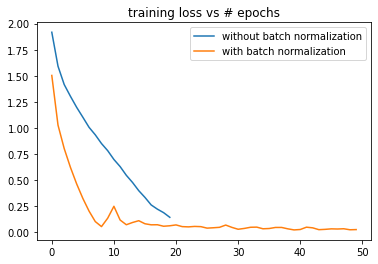

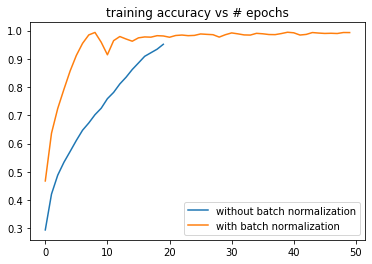

In [29]:
plt.figure()
plt.plot(SimpleConvnet_train_losses, label = 'without batch normalization')
plt.plot(SimpleConvnet2_train_losses, label = 'with batch normalization')
plt.legend()
plt.title('training loss vs # epochs')
plt.show()

plt.figure()
plt.plot(SimpleConvnet_train_accuracies, label = 'without batch normalization')
plt.plot(SimpleConvnet2_train_accuracies, label = 'with batch normalization')
plt.legend()
plt.title('training accuracy vs # epochs')
plt.show()

Comment: with Adam optimizer, both SimpleNet and SimpleNet2 have the capacity to memorize training data. The same as we observe in the case with a SGD optimizer, with batch normalization the weights update to the optimal direction, and the losses converge much more faster. 

#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 


In [24]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TODO : Run the training loop using this model
SimpleConvnet2_single_loss, SimpleConvnet2_single_acc, _, _ = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'check_capacity', log_print = True, max_patience = 100, max_iter=50, check_capacity = True)

[EPOCH]: 0, [TRAIN LOSS]: 1.481186, [TRAIN ACCURACY]: 0.471
[EPOCH]: 0, [VAL LOSS]: 1.188128, [VAL ACCURACY]: 0.574 

[EPOCH]: 1, [TRAIN LOSS]: 1.008148, [TRAIN ACCURACY]: 0.644
[EPOCH]: 1, [VAL LOSS]: 0.977223, [VAL ACCURACY]: 0.658 

[EPOCH]: 2, [TRAIN LOSS]: 0.772573, [TRAIN ACCURACY]: 0.734
[EPOCH]: 2, [VAL LOSS]: 0.877357, [VAL ACCURACY]: 0.692 

[EPOCH]: 3, [TRAIN LOSS]: 0.595199, [TRAIN ACCURACY]: 0.805
[EPOCH]: 3, [VAL LOSS]: 0.870802, [VAL ACCURACY]: 0.696 

[EPOCH]: 4, [TRAIN LOSS]: 0.442249, [TRAIN ACCURACY]: 0.863
[EPOCH]: 4, [VAL LOSS]: 0.780226, [VAL ACCURACY]: 0.729 

[EPOCH]: 5, [TRAIN LOSS]: 0.301344, [TRAIN ACCURACY]: 0.918
[EPOCH]: 5, [VAL LOSS]: 0.770610, [VAL ACCURACY]: 0.735 

[EPOCH]: 6, [TRAIN LOSS]: 0.181339, [TRAIN ACCURACY]: 0.960
[EPOCH]: 6, [VAL LOSS]: 0.790613, [VAL ACCURACY]: 0.737 

[EPOCH]: 7, [TRAIN LOSS]: 0.088550, [TRAIN ACCURACY]: 0.986
[EPOCH]: 7, [VAL LOSS]: 0.817502, [VAL ACCURACY]: 0.742 

[EPOCH]: 8, [TRAIN LOSS]: 0.061523, [TRAIN ACCURACY]: 0.

I modified the training loop function so that with a switch 'check_capacity = True', the function would stop and print 'There is one batch achieving 100% accuracy' if there is a batch of training data are all classified correctly.

### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the input_channels, output_channels, kernel_size and padding parameters. 

In [10]:
class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        # TODO
        self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=1, padding=0)
        self.conv12 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=1, padding=0)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.batchnorm7 = nn.BatchNorm2d(128)
        self.batchnorm8 = nn.BatchNorm2d(256)
        self.batchnorm9 = nn.BatchNorm2d(256)
        self.batchnorm10 = nn.BatchNorm2d(256)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=8) ################## need confirm
        self.view = View((-1,256))
        self.linear = nn.Linear(256, num_classes)
    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        y1 = self.conv1(x)
        y2 = self.relu(y1)
        y = self.batchnorm1(y2)

        # HINT: block of 3 conv 
        l1 = self.conv2(y)
        l2 = self.relu(l1)
        b2 = self.batchnorm2(l2)
        l3 = self.conv3(b2)
        l4 = self.relu(l3)
        b3 = self.batchnorm3(l4)
        l5 = self.conv4(b3)
        l6 = self.relu(l5) + y
        b4 = self.batchnorm4(l6)
        l = self.maxpool1(b4)

        # HINT : block of 3 conv 
        m1 = self.conv5(l)
        m2 = self.relu(m1)
        b5 = self.batchnorm5(m2)
        m3 = self.conv6(b5)
        m4 = self.relu(m3)
        b6 = self.batchnorm6(m4)
        m5 = self.conv7(b6)
        m6 = self.relu(m5) + self.conv11(l)
        b7 = self.batchnorm7(m6)
        m = self.maxpool2(b7)

        # HINT: block of 3 conv
        n1 = self.conv8(m)
        n2 = self.relu(n1)
        b8 = self.batchnorm8(n2)
        n3 = self.conv9(b8)
        n4 = self.relu(n3)
        b9 = self.batchnorm9(n4)
        n5 = self.conv10(b9)
        n6 = self.relu(n5) + self.conv12(m)
        b10 = self.batchnorm10(n6)
        n = self.maxpool3(b10)

        # HINT: projection
        out = self.view(n)
        output = self.linear(out)
        
        return output

In [31]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TODO : Run the training loop using this model
Residual_train_losses, Residual_train_accuracies, Residual_val_losses, Residual_val_accuracies = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'ResidualConvnet')

[EPOCH]: 0, [TRAIN LOSS]: 1.371359, [TRAIN ACCURACY]: 0.513
[EPOCH]: 0, [VAL LOSS]: 1.068622, [VAL ACCURACY]: 0.634 

[EPOCH]: 1, [TRAIN LOSS]: 0.898953, [TRAIN ACCURACY]: 0.693
[EPOCH]: 1, [VAL LOSS]: 0.901947, [VAL ACCURACY]: 0.685 

[EPOCH]: 2, [TRAIN LOSS]: 0.675296, [TRAIN ACCURACY]: 0.775
[EPOCH]: 2, [VAL LOSS]: 0.827704, [VAL ACCURACY]: 0.708 

[EPOCH]: 3, [TRAIN LOSS]: 0.502138, [TRAIN ACCURACY]: 0.845
[EPOCH]: 3, [VAL LOSS]: 0.750768, [VAL ACCURACY]: 0.739 

[EPOCH]: 4, [TRAIN LOSS]: 0.353351, [TRAIN ACCURACY]: 0.903
[EPOCH]: 4, [VAL LOSS]: 0.708997, [VAL ACCURACY]: 0.754 

[EPOCH]: 5, [TRAIN LOSS]: 0.224369, [TRAIN ACCURACY]: 0.952
[EPOCH]: 5, [VAL LOSS]: 0.711081, [VAL ACCURACY]: 0.754 

[EPOCH]: 6, [TRAIN LOSS]: 0.118184, [TRAIN ACCURACY]: 0.986
[EPOCH]: 6, [VAL LOSS]: 0.689885, [VAL ACCURACY]: 0.765 

[EPOCH]: 7, [TRAIN LOSS]: 0.055261, [TRAIN ACCURACY]: 0.997
[EPOCH]: 7, [VAL LOSS]: 0.697245, [VAL ACCURACY]: 0.770 

[EPOCH]: 8, [TRAIN LOSS]: 0.023125, [TRAIN ACCURACY]: 1.

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

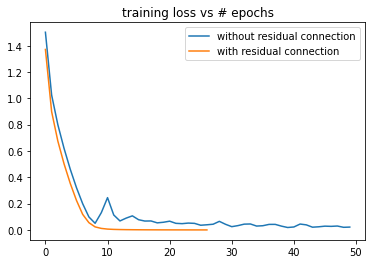

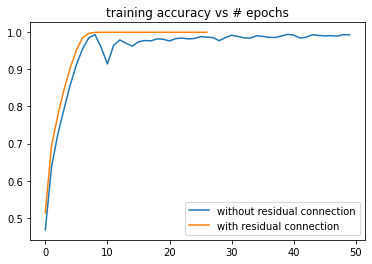

In [32]:
plt.figure()
plt.plot(SimpleConvnet2_train_losses, label = 'without residual connection')
plt.plot(Residual_train_losses, label = 'with residual connection')
plt.legend()
plt.title('training loss vs # epochs')
plt.show()

plt.figure()
plt.plot(SimpleConvnet2_train_accuracies, label = 'without residual connection')
plt.plot(Residual_train_accuracies, label = 'with residual connection')
plt.legend()
plt.title('training accuracy vs # epochs')
plt.show()

Comment: with the residual connection, training losses converge faster and more smoothly. For a deep neural network, residual connection can mitigate the problem of gradient vanishing.

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding random transformations to the input data to make your model more robust and prevent it from memorizing the input data. 

Torchvision provides several transforms that you can readily apply to your data. Experiment with adding a few transforms and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and try to achieve better perfomance on the validation set. 

In [18]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [19]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [27]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)

#### Use the residual network that you built above and use data augmentation to reduce the overfitting 

In [36]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the Adam optimizer with lr 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TODO : Run the training loop using this model
Residual_train_losses, Residual_train_accuracies, Residual_val_losses, Residual_val_accuracies = \
train_loop(model, criterion, optimizer,  train_loader, val_loader, 'ResidualConvnet_augmented')

[EPOCH]: 0, [TRAIN LOSS]: 1.526810, [TRAIN ACCURACY]: 0.459
[EPOCH]: 0, [VAL LOSS]: 1.266728, [VAL ACCURACY]: 0.551 

[EPOCH]: 1, [TRAIN LOSS]: 1.055605, [TRAIN ACCURACY]: 0.627
[EPOCH]: 1, [VAL LOSS]: 0.952522, [VAL ACCURACY]: 0.664 

[EPOCH]: 2, [TRAIN LOSS]: 0.854725, [TRAIN ACCURACY]: 0.702
[EPOCH]: 2, [VAL LOSS]: 0.836344, [VAL ACCURACY]: 0.704 

[EPOCH]: 3, [TRAIN LOSS]: 0.724410, [TRAIN ACCURACY]: 0.749
[EPOCH]: 3, [VAL LOSS]: 0.711247, [VAL ACCURACY]: 0.756 

[EPOCH]: 4, [TRAIN LOSS]: 0.635034, [TRAIN ACCURACY]: 0.781
[EPOCH]: 4, [VAL LOSS]: 0.632256, [VAL ACCURACY]: 0.782 

[EPOCH]: 5, [TRAIN LOSS]: 0.565373, [TRAIN ACCURACY]: 0.805
[EPOCH]: 5, [VAL LOSS]: 0.617550, [VAL ACCURACY]: 0.781 

[EPOCH]: 6, [TRAIN LOSS]: 0.513261, [TRAIN ACCURACY]: 0.825
[EPOCH]: 6, [VAL LOSS]: 0.554081, [VAL ACCURACY]: 0.809 

[EPOCH]: 7, [TRAIN LOSS]: 0.467915, [TRAIN ACCURACY]: 0.839
[EPOCH]: 7, [VAL LOSS]: 0.534341, [VAL ACCURACY]: 0.817 

[EPOCH]: 8, [TRAIN LOSS]: 0.432999, [TRAIN ACCURACY]: 0.

### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [16]:
from torch.optim.lr_scheduler import StepLR

In [23]:
def train_loop2(model, criterion, optimizer, scheduler, train_loader, val_loader, model_name, log_print = True, max_patience = 5, max_iter=50):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = max_patience
    patience_counter = 0

    # Training
    for t in tqdm(range(max_iter)):

        # TODO : Set the model to train mode
        model.train()   

        # TODO: Loop over the training set 
        correct, total, train_loss = 0, 0, 0
        for inputs, targets in train_loader:

            # TODO: Put the inputs and targets on the write device
            inputs, targets = inputs.to(device), targets.to(device)

            # TODO: Feed forward to get the logits
            logits = model(inputs)

            # TODO: Compute the loss and accuracy
            loss = criterion(logits, targets)
            train_loss += targets.size(0) * loss.item()
            _, predicted = torch.max(logits, 1)
            correct += predicted.eq(targets).cpu().sum().item()
            total += targets.size(0)

            # TODO: zero the gradients before running
            # the backward pass.
            model.zero_grad()

            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()

            # TODO: Update params
            optimizer.step()

            # TODO: Keep track of accuracy and loss
        train_losses.append(train_loss/total)
        train_accuracies.append(correct/total)

        
        # TODO: Switch the model to eval mode
        model.eval()
        with torch.no_grad():
            # TODO: Loop over the validation set
            val_correct, val_total, val_loss = 0, 0, 0
            for inputs, targets in val_loader:
            
                # TODO: Put the inputs and targets on the write device
                inputs, targets = inputs.to(device), targets.to(device)
            
                # TODO: Feed forward to get the logits
                logits = model(inputs)

                # TODO: Compute the loss and accuracy
                loss = criterion(logits, targets)
                val_loss += targets.size(0) * loss.item()
                _, predicted = torch.max(logits, 1)
                val_correct += predicted.eq(targets).cpu().sum().item()
                val_total += targets.size(0)

                # TODO: Keep track of accuracy and loss
            val_losses.append(val_loss/val_total)
            val_accuracies.append(val_correct/val_total)

        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          torch.save({
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': t,
              }, '/content/drive/My Drive/1008_DL_Homework2/model_checkpoints/{}_checkpoint.pth'.format(model_name))

          
        else:
          patience_counter += 1    
          if patience_counter > max_patience: 
            break

        if log_print == True:
          print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
          print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

        # TODO : scheduler step
        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

In [42]:
# TODO : Initialize the model and cast to correct device
model = ResidualConvnet(input_channels = 3, num_classes = 10)
model = model.cuda()

# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()

# TODO : Initialize the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# TODO : Initialize the scheduler
scheduler = StepLR(optimizer, step_size=20, gamma = 0.2)

# TODO : Run the training loop using this model
Residual_train_losses_sched, Residual_train_accuracies_sched, Residual_val_losses_sched, Residual_val_accuracies_sched = \
train_loop2(model, criterion, optimizer, scheduler, train_loader, val_loader, 'ResidualConvnet_augmented_stepLR')

[EPOCH]: 0, [TRAIN LOSS]: 1.485498, [TRAIN ACCURACY]: 0.468
[EPOCH]: 0, [VAL LOSS]: 1.170151, [VAL ACCURACY]: 0.587 

[EPOCH]: 1, [TRAIN LOSS]: 1.047305, [TRAIN ACCURACY]: 0.632
[EPOCH]: 1, [VAL LOSS]: 0.990119, [VAL ACCURACY]: 0.657 

[EPOCH]: 2, [TRAIN LOSS]: 0.866059, [TRAIN ACCURACY]: 0.697
[EPOCH]: 2, [VAL LOSS]: 0.820833, [VAL ACCURACY]: 0.711 

[EPOCH]: 3, [TRAIN LOSS]: 0.739697, [TRAIN ACCURACY]: 0.743
[EPOCH]: 3, [VAL LOSS]: 0.728664, [VAL ACCURACY]: 0.745 

[EPOCH]: 4, [TRAIN LOSS]: 0.646244, [TRAIN ACCURACY]: 0.777
[EPOCH]: 4, [VAL LOSS]: 0.656059, [VAL ACCURACY]: 0.770 

[EPOCH]: 5, [TRAIN LOSS]: 0.574132, [TRAIN ACCURACY]: 0.802
[EPOCH]: 5, [VAL LOSS]: 0.611124, [VAL ACCURACY]: 0.784 

[EPOCH]: 6, [TRAIN LOSS]: 0.522178, [TRAIN ACCURACY]: 0.821
[EPOCH]: 6, [VAL LOSS]: 0.560826, [VAL ACCURACY]: 0.803 

[EPOCH]: 7, [TRAIN LOSS]: 0.471295, [TRAIN ACCURACY]: 0.840
[EPOCH]: 7, [VAL LOSS]: 0.541184, [VAL ACCURACY]: 0.812 

[EPOCH]: 8, [TRAIN LOSS]: 0.430522, [TRAIN ACCURACY]: 0.

### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





##### 5 different learning rate with SGD optimizer

In [18]:
lr_parameters = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
training_losses, validation_losses = [], []
for lr in lr_parameters:
  # TODO : Initialize the model and cast to correct device
  model = ResidualConvnet(input_channels = 3, num_classes = 10)
  model = model.cuda()
  # TODO : Initialize the criterion
  criterion = nn.CrossEntropyLoss()
  # TODO : Initialize the optimizer 
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  # TODO : Run the training loop using this model
  train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model, criterion, optimizer, train_loader, val_loader, 'ResidualConvnet_SGD_'+str(lr), log_print = False)
  training_losses.append(train_losses)
  validation_losses.append(val_losses)

Text(0.5, 1.0, 'SGD: validation loss vs # epoch')

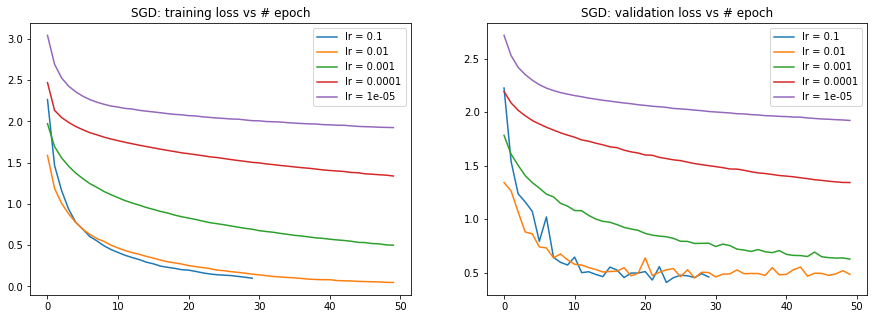

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(lr_parameters)):
  plt.plot(training_losses[i], label = 'lr = {}'.format(lr_parameters[i]))
plt.legend()
plt.title('SGD: training loss vs # epoch')

plt.subplot(1,2,2)
for i in range(len(lr_parameters)):
  plt.plot(validation_losses[i], label = 'lr = {}'.format(lr_parameters[i]))
plt.legend()
plt.title('SGD: validation loss vs # epoch')

##### 5 different learning rate with Adam optimizer

In [21]:
lr_parameters = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
training_losses, validation_losses = [], []
for lr in lr_parameters:
  # TODO : Initialize the model and cast to correct device
  model = ResidualConvnet(input_channels = 3, num_classes = 10)
  model = model.cuda()
  # TODO : Initialize the criterion
  criterion = nn.CrossEntropyLoss()
  # TODO : Initialize the optimizer 
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # TODO : Run the training loop using this model
  train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model, criterion, optimizer, train_loader, val_loader, 'ResidualConvnet_Adam_'+str(lr), log_print = False)
  training_losses.append(train_losses)
  validation_losses.append(val_losses)

Text(0.5, 1.0, 'Adam: validation loss vs # epoch')

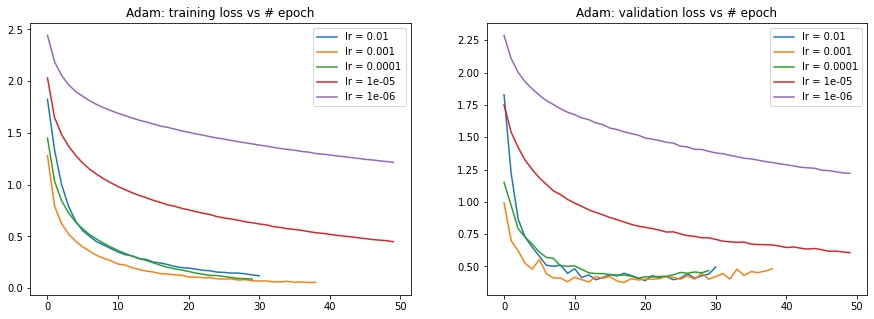

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(lr_parameters)):
  plt.plot(training_losses[i], label = 'lr = {}'.format(lr_parameters[i]))
plt.legend()
plt.title('Adam: training loss vs # epoch')

plt.subplot(1,2,2)
for i in range(len(lr_parameters)):
  plt.plot(validation_losses[i], label = 'lr = {}'.format(lr_parameters[i]))
plt.legend()
plt.title('Adam: validation loss vs # epoch')

##### After comparing the performances associated with the two optimizers and the parameter settings, I decide to use Adam and lr = 0.001. To better leverage scheduler, I train 100 epochs and set the patience = 10, scheduler = 20.

In [30]:
gamma_parameters = [0.8, 0.5, 0.2, 0.1, 0.08, 0.05]
training_losses, validation_losses, training_accs, validation_accs = [], [], [], []
for gamma in gamma_parameters:
  # TODO : Initialize the model and cast to correct device
  model = ResidualConvnet(input_channels = 3, num_classes = 10)
  model = model.cuda()
  # TODO : Initialize the criterion
  criterion = nn.CrossEntropyLoss()
  # TODO : Initialize the optimizer 
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  # TODO : Initialize the scheduler
  scheduler = StepLR(optimizer, step_size=20, gamma = gamma)
  # TODO : Run the training loop using this model
  train_losses, train_accuracies, val_losses, val_accuracies = train_loop2(model, criterion, optimizer, scheduler, train_loader, val_loader, 'ResidualConvnet_Adam_Step_'+str(gamma), 
                                                                           log_print = False, max_patience = 10, max_iter=100)
  training_losses.append(train_losses)
  validation_losses.append(val_losses)
  training_accs.append(train_accuracies)
  validation_accs.append(val_accuracies)

Text(0.5, 1.0, 'Adam with scheduler: validation loss vs # epoch')

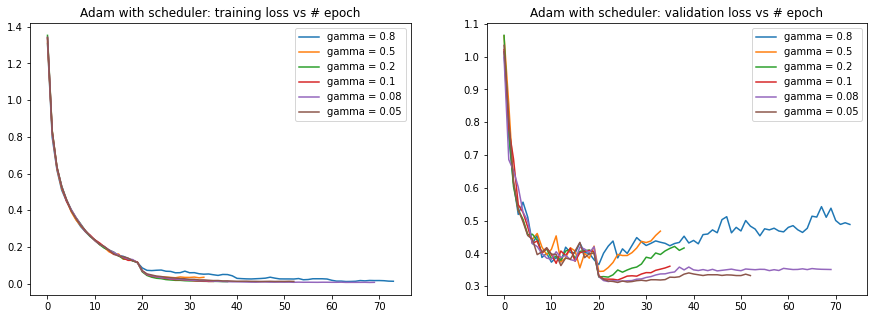

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(gamma_parameters)):
  plt.plot(training_losses[i], label = 'gamma = {}'.format(gamma_parameters[i]))
plt.legend()
plt.title('Adam with scheduler: training loss vs # epoch')

plt.subplot(1,2,2)
for i in range(len(gamma_parameters)):
  plt.plot(validation_losses[i], label = 'gamma = {}'.format(gamma_parameters[i]))
plt.legend()
plt.title('Adam with scheduler: validation loss vs # epoch')

In [33]:
for accs in validation_accs:
  print(max(accs))

0.9144
0.9054
0.9108
0.9149
0.9173
0.9179


### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 

From the last question, the model gave the best validation accuracy has parameters {lr = 0.001, optimizer = Adam, gamma = 0.05}

In [28]:
pretrained_model = ResidualConvnet(input_channels = 3, num_classes = 10)
pretrained_model = pretrained_model.cuda()
model_state = torch.load('/content/drive/My Drive/1008_DL_Homework2/model_checkpoints/ResidualConvnet_Adam_Step_0.05_checkpoint.pth')['model']
pretrained_model.load_state_dict(model_state)
criterion = nn.CrossEntropyLoss()

In [32]:
pretrained_model.eval()
with torch.no_grad():
  # TODO: Loop over the test set
  test_correct, test_total, test_loss = 0, 0, 0
  for inputs, targets in test_loader:
    # TODO: Put the inputs and targets on the write device
    inputs, targets = inputs.to(device), targets.to(device)
    # TODO: Feed forward to get the logits
    logits = pretrained_model(inputs)

    # TODO: Compute the loss and accuracy
    loss = criterion(logits, targets)
    test_loss += targets.size(0) * loss.item()
    _, predicted = torch.max(logits, 1)
    test_correct += predicted.eq(targets).cpu().sum().item()
    test_total += targets.size(0)

  # TODO: Print test results
  print('Test loss of the model with best test accuracy is {}'.format(test_loss/test_total))
  print('Test accuracy of the model with best test accuracy is {}'.format(test_correct/test_total))

Test loss of the model with best test accuracy is 0.37411808881759645
Test accuracy of the model with best test accuracy is 0.9103
